# Titanic Survival Prediction

***This notebook demonstrates an end-to-end machine learning workflow on the Kaggle Titanic dataset.
The focus is on feature engineering, model evaluation, regularization, and decision-making rather
than leaderboard-only optimization.***

## 1. Imports and Configuration

In [1]:
# sanity check
import os
os.getcwd(), os.listdir()

('C:\\Users\\Pranav Kumar Mohanan\\Downloads\\titanic',
 ['.ipynb_checkpoints',
  'gender_submission.csv',
  'submission.csv',
  'test.csv',
  'Titanic-Final.ipynb',
  'Titanic-Final1.ipynb',
  'Titanic.ipynb',
  'train.csv',
  'Untitled.ipynb'])

## 2. Data Loading

In [2]:
# Load the data
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Understand the data shape & target
train.shape, test.shape

((891, 12), (418, 11))

In [4]:
# Understand the data shape & target
train['Survived'].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [5]:
# Column overview
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Missing values
train.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [7]:
# Quick survival insights
train.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [8]:
# Quick survival insights
train.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [9]:
# Quick survival insights
train.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

In [10]:
# Age sanity check
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

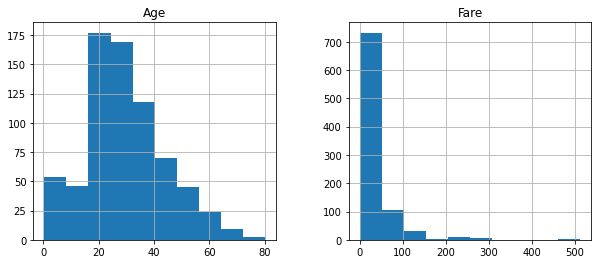

In [11]:
# Age sanity check
train[['Age', 'Fare']].hist(figsize=(10,4))

## 3. Combine Train and Test Datasets

### WHAT:
**- Create a single dataframe containing train + test
**- Preserve target column with NaN for test rows

### WHY:
**- Allows uniform feature engineering
**- Enables clean train/test split later

In [12]:
# =======================================================
# BLOCK 1: Combine raw train and test datasets (CORRECT)
# =======================================================

# Add Survived column to test (as NaN)
test['Survived'] = np.nan

# Combine
data = pd.concat(
    [train, test],
    axis=0,
    ignore_index=True
)

In [13]:
# -------------------------------------------------------
# SANITY CHECK 1: Combined shape
# -------------------------------------------------------
print("Combined data shape:", data.shape)
print("Expected rows:", train.shape[0] + test.shape[0])

# -------------------------------------------------------
# SANITY CHECK 2: Target column removed
# -------------------------------------------------------
print("'Survived' in data columns:", 'Survived' in data.columns)

# -------------------------------------------------------
# SANITY CHECK 3: Raw columns still present
# (We NEED these for upcoming blocks)
# -------------------------------------------------------
required_raw_cols = ['Cabin', 'Ticket', 'Name', 'PassengerId']

for col in required_raw_cols:
    print(f"{col} present:", col in data.columns)

print("Combined data shape:", data.shape)
print("'Survived' in data columns:", 'Survived' in data.columns)
print("Survived NaNs (should equal test size):", data['Survived'].isnull().sum())

Combined data shape: (1309, 12)
Expected rows: 1309
'Survived' in data columns: True
Cabin present: True
Ticket present: True
Name present: True
PassengerId present: True
Combined data shape: (1309, 12)
'Survived' in data columns: True
Survived NaNs (should equal test size): 418


## Feature Engineering

## Cabin-based features

**WHAT:
*- Create HasCabin flag
*- Extract CabinDeck (first letter)
*- Encode CabinDeck

**WHY:
*- Cabin presence is a strong proxy for wealth
*- Deck roughly indicates physical location on ship
*- Raw Cabin is too noisy, but these signals are robust

**IMPORTANT:
*- Do NOT drop 'Cabin' in this block
*- Other blocks may still depend on raw columns

In [14]:
# -------------------------------------------------------
# STEP 2.1: HasCabin flag
# WHAT: 1 if Cabin is present, else 0
# WHY: Wealth + access proxy
# -------------------------------------------------------

data['HasCabin'] = data['Cabin'].notnull().astype(int)

In [15]:
# -------------------------------------------------------
# SANITY CHECK: HasCabin distribution
# -------------------------------------------------------
data['HasCabin'].value_counts()

HasCabin
0    1014
1     295
Name: count, dtype: int64

In [16]:
# -------------------------------------------------------
# STEP 2.2: Extract CabinDeck
# WHAT: First letter of Cabin (A–G)
# WHY: Rough deck / vertical location
# -------------------------------------------------------

data['CabinDeck'] = data['Cabin'].str[0]

In [17]:
# -------------------------------------------------------
# STEP 2.3: Handle missing CabinDeck
# WHAT: Fill missing decks as 'Unknown'
# WHY: Missing itself carries information
# -------------------------------------------------------

data['CabinDeck'] = data['CabinDeck'].fillna('Unknown')

In [18]:
# -------------------------------------------------------
# SANITY CHECK: CabinDeck distribution
# -------------------------------------------------------
data['CabinDeck'].value_counts()

CabinDeck
Unknown    1014
C            94
B            65
D            46
E            41
A            22
F            21
G             5
T             1
Name: count, dtype: int64

In [19]:
# -------------------------------------------------------
# STEP 2.4: One-hot encode CabinDeck
# WHAT: Convert categorical deck to numeric
# WHY: Required for ML models
# -------------------------------------------------------

data = pd.get_dummies(
    data,
    columns=['CabinDeck'],
    drop_first=True
)

In [20]:
# -------------------------------------------------------
# SANITY CHECK: Encoded CabinDeck columns
# -------------------------------------------------------
[c for c in data.columns if c.startswith('CabinDeck_')]

['CabinDeck_B',
 'CabinDeck_C',
 'CabinDeck_D',
 'CabinDeck_E',
 'CabinDeck_F',
 'CabinDeck_G',
 'CabinDeck_T',
 'CabinDeck_Unknown']

In [21]:
# -------------------------------------------------------
# SANITY CHECK: Missing values after Block 2
# -------------------------------------------------------
print("Total missing values:", data.isnull().sum().sum())

# -------------------------------------------------------
# SANITY CHECK: Cabin still present (must be TRUE)
# -------------------------------------------------------
print("'Cabin' still present:", 'Cabin' in data.columns)

Total missing values: 1698
'Cabin' still present: True


## Ticket-based features

**WHAT:
*- Compute TicketGroupSize
*- Compute FarePerPerson

**WHY:
*- Shared tickets indicate group travel
*- Group size affects evacuation dynamics
*- FarePerPerson is a cleaner wealth proxy than Fare

**IMPORTANT:
*- Do NOT drop 'Ticket' or 'Fare' yet

In [22]:
# -------------------------------------------------------
# STEP 3.1: TicketGroupSize
# WHAT: Number of passengers sharing the same ticket
# WHY: Capture group travel / evacuation behavior
# -------------------------------------------------------

data['TicketGroupSize'] = data.groupby('Ticket')['Ticket'].transform('count')

In [23]:
# -------------------------------------------------------
# SANITY CHECK: TicketGroupSize distribution
# -------------------------------------------------------
data['TicketGroupSize'].value_counts().sort_index()

TicketGroupSize
1     713
2     264
3     147
4      64
5      35
6      24
7      35
8      16
11     11
Name: count, dtype: int64

In [24]:
# SANITY CHECK: Sample Ticket vs group size
data[['Ticket', 'TicketGroupSize']].sample(10)

,Ticket,TicketGroupSize
96,PC 17754,1
310,11767,3
1133,16966,5
1166,236853,2
712,19996,2
924,W./C. 6607,4
672,C.A. 24580,1
633,112052,1
182,347077,7
198,370370,1


In [25]:
# -------------------------------------------------------
# STEP 3.2: FarePerPerson
# WHAT: Fare divided by TicketGroupSize
# WHY: Better proxy for individual wealth
# -------------------------------------------------------

data['FarePerPerson'] = data['Fare'] / data['TicketGroupSize']

In [26]:
# -------------------------------------------------------
# SANITY CHECK: FarePerPerson basic stats
# -------------------------------------------------------
data['FarePerPerson'].describe()

count    1308.000000
mean       14.757627
std        13.555638
min         0.000000
25%         7.550000
50%         8.050000
75%        15.008325
max       128.082300
Name: FarePerPerson, dtype: float64

In [27]:
# SANITY CHECK: Compare Fare vs FarePerPerson
data[['Fare', 'TicketGroupSize', 'FarePerPerson']].sample(10)

,Fare,TicketGroupSize,FarePerPerson
359,7.8792,1,7.879200
328,20.5250,3,6.841667
509,56.4958,8,7.061975
92,61.1750,2,30.587500
105,7.8958,1,7.895800
425,7.2500,1,7.250000
215,113.2750,3,37.758333
12,8.0500,1,8.050000
1031,46.9000,8,5.862500
832,7.2292,1,7.229200


In [28]:
# -------------------------------------------------------
# SANITY CHECK: Missing values after Block 3
# -------------------------------------------------------
print("Missing values by column:")
print(data[['Fare', 'TicketGroupSize', 'FarePerPerson']].isnull().sum())

# -------------------------------------------------------
# SANITY CHECK: Ticket still present (must be TRUE)
# -------------------------------------------------------
print("'Ticket' still present:", 'Ticket' in data.columns)

Missing values by column:
Fare               1
TicketGroupSize    0
FarePerPerson      1
dtype: int64
'Ticket' still present: True


## Title-based features (from Name)

**WHAT:
*- Extract title from passenger Name
*- Normalize rare titles into a single category
*- Encode titles numerically

**WHY:
*- Title captures gender, age, and social status
*- Strong survival signal on Titanic

**IMPORTANT:
*- Do NOT drop 'Name' yet

In [29]:
# -------------------------------------------------------
# STEP 4.1: Extract Title
# WHAT: Extract title string from Name
# WHY: Titles encode social and demographic information
# -------------------------------------------------------

data['Title'] = data['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

In [30]:
# -------------------------------------------------------
# SANITY CHECK: Raw title distribution
# -------------------------------------------------------
data['Title'].value_counts()

Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [31]:
# -------------------------------------------------------
# STEP 4.2: Normalize rare titles
# WHAT: Group infrequent titles into 'Rare'
# WHY: Reduce noise and sparsity
# -------------------------------------------------------

rare_titles = [
    'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr',
    'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'
]

data['Title'] = data['Title'].replace(rare_titles, 'Rare')

In [32]:
# -------------------------------------------------------
# SANITY CHECK: Normalized title distribution
# -------------------------------------------------------
data['Title'].value_counts()

Title
Mr              757
Miss            260
Mrs             197
Master           61
Rare             28
Ms                2
Mlle              2
Mme               1
the Countess      1
Name: count, dtype: int64

In [33]:
# -------------------------------------------------------
# STEP 4.3: One-hot encode Title
# WHAT: Convert categorical Title into numeric columns
# WHY: Required for ML models
# -------------------------------------------------------

data = pd.get_dummies(
    data,
    columns=['Title'],
    drop_first=True
)

In [34]:
# -------------------------------------------------------
# SANITY CHECK: Encoded Title columns
# -------------------------------------------------------
[c for c in data.columns if c.startswith('Title_')]

['Title_Miss',
 'Title_Mlle',
 'Title_Mme',
 'Title_Mr',
 'Title_Mrs',
 'Title_Ms',
 'Title_Rare',
 'Title_the Countess']

In [35]:
# -------------------------------------------------------
# SANITY CHECK: Name still present (must be TRUE)
# -------------------------------------------------------
print("'Name' still present:", 'Name' in data.columns)

# -------------------------------------------------------
# SANITY CHECK: Missing values introduced?
# -------------------------------------------------------
print("Total missing values:", data.isnull().sum().sum())

'Name' still present: True
Total missing values: 1699


## Family-based features

**WHAT:
*- Create FamilySize feature
*- Create IsAlone flag
*- (Optional) Create FamilyType categorical feature

**WHY:
*- Family structure strongly affects survival
*- Captures evacuation group behavior

**IMPORTANT:
*- Do NOT drop SibSp or Parch yet

In [36]:
# -------------------------------------------------------
# STEP 5.1: FamilySize
# WHAT: Total family members onboard including self
# WHY: Small families survived more than very large ones
# -------------------------------------------------------

data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

In [37]:
# -------------------------------------------------------
# SANITY CHECK: FamilySize distribution
# -------------------------------------------------------
data['FamilySize'].value_counts().sort_index()

FamilySize
1     790
2     235
3     159
4      43
5      22
6      25
7      16
8       8
11     11
Name: count, dtype: int64

In [38]:
# -------------------------------------------------------
# STEP 5.2: IsAlone flag
# WHAT: 1 if passenger traveled alone, else 0
# WHY: Solo travelers had lower survival rates
# -------------------------------------------------------

data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

In [39]:
# -------------------------------------------------------
# SANITY CHECK: IsAlone distribution
# -------------------------------------------------------
data['IsAlone'].value_counts()

IsAlone
1    790
0    519
Name: count, dtype: int64

In [40]:
# SANITY CHECK: FamilySize vs IsAlone
data[['FamilySize', 'IsAlone']].sample(10)

,FamilySize,IsAlone
361,2,0
836,1,1
621,2,0
952,1,1
306,1,1
1224,3,0
234,1,1
1301,1,1
393,2,0
598,1,1


In [41]:
# -------------------------------------------------------
# STEP 5.3: FamilyType
# WHAT: Categorize family size into groups
# WHY: Capture non-linear family effects
# -------------------------------------------------------

data['FamilyType'] = pd.cut(
    data['FamilySize'],
    bins=[0, 1, 4, 7, 20],
    labels=['Alone', 'Small', 'Medium', 'Large']
)

In [42]:
# -------------------------------------------------------
# STEP 5.4: Encode FamilyType
# WHAT: One-hot encode FamilyType
# WHY: Make categorical family groups usable by models
# -------------------------------------------------------

data = pd.get_dummies(
    data,
    columns=['FamilyType'],
    drop_first=True
)

In [43]:
# -------------------------------------------------------
# SANITY CHECK: FamilyType encoded columns
# -------------------------------------------------------
[c for c in data.columns if c.startswith('FamilyType_')]

['FamilyType_Small', 'FamilyType_Medium', 'FamilyType_Large']

In [44]:
# -------------------------------------------------------
# SANITY CHECK: Missing values after Block 5
# -------------------------------------------------------
print("Total missing values:", data.isnull().sum().sum())

# -------------------------------------------------------
# SANITY CHECK: Core family columns still present
# -------------------------------------------------------
print("SibSp present:", 'SibSp' in data.columns)
print("Parch present:", 'Parch' in data.columns)

Total missing values: 1699
SibSp present: True
Parch present: True


## Missing value handling

**WHAT:
*- Fill missing Embarked
*- Fill missing Fare
*- Smart Age imputation using group medians

**WHY:
*- Models cannot handle NaNs
*- Age is non-randomly missing
*- Group-based imputation preserves structure

**IMPORTANT:
*- Do NOT drop any columns here
*- Do NOT bin Age here (comes later)

In [45]:
# -------------------------------------------------------
# STEP 6.1: Fill missing Embarked
# WHAT: Use most frequent port
# WHY: Very few missing values
# -------------------------------------------------------

data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

In [46]:
# -------------------------------------------------------
# SANITY CHECK: Embarked missing values
# -------------------------------------------------------
data['Embarked'].isnull().sum()

0

In [47]:
# -------------------------------------------------------
# STEP 6.2: Fill missing Fare
# WHAT: Use median Fare
# WHY: Robust to skewed distribution
# -------------------------------------------------------

data['Fare'] = data['Fare'].fillna(data['Fare'].median())

In [48]:
# -------------------------------------------------------
# STEP 6.3: Recompute FarePerPerson after Fare imputation
# -------------------------------------------------------

data['FarePerPerson'] = data['Fare'] / data['TicketGroupSize']

In [49]:
# -------------------------------------------------------
# SANITY CHECK: Fare and FarePerPerson
# -------------------------------------------------------
data[['Fare', 'FarePerPerson']].isnull().sum()

Fare             0
FarePerPerson    0
dtype: int64

## Age Imputation

In [50]:
# -------------------------------------------------------
# STEP 6.4 (ROBUST): Two-stage smart Age imputation
# -------------------------------------------------------

# Re-extract Title for age logic
data['_Title_for_Age'] = data['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

rare_titles = [
    'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr',
    'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'
]
data['_Title_for_Age'] = data['_Title_for_Age'].replace(rare_titles, 'Rare')

# Stage 1: Title + Sex (stable groups)
data['Age'] = data.groupby(
    ['_Title_for_Age', 'Sex'],
    dropna=False
)['Age'].transform(lambda x: x.fillna(x.median()))

# Stage 2: Global fallback
data['Age'] = data['Age'].fillna(data['Age'].median())

data.drop(columns=['_Title_for_Age'], inplace=True)

In [51]:
# -------------------------------------------------------
# SANITY CHECK: Age missing values
# -------------------------------------------------------
data['Age'].isnull().sum()

0

In [52]:
# SANITY CHECK: Age summary after imputation
data['Age'].describe()

count    1309.000000
mean       29.431757
std        13.162660
min         0.170000
25%        22.000000
50%        29.000000
75%        35.500000
max        80.000000
Name: Age, dtype: float64

## Encode remaining categorical variables

**WHAT:
*- One-hot encode Sex and Embarked

**WHY:
*- Models require numeric inputs
*- Low-cardinality categoricals → perfect for OHE

**IMPORTANT:
*- Drop first to avoid multicollinearity

In [53]:
data = pd.get_dummies(
    data,
    columns=['Sex', 'Embarked'],
    drop_first=True
)

In [54]:
print([c for c in data.columns if c.startswith('Sex_')])
print([c for c in data.columns if c.startswith('Embarked_')])

['Sex_male']
['Embarked_Q', 'Embarked_S']


In [55]:
# -------------------------------------------------------
# SANITY CHECK: Remaining missing values (should be 0)
# -------------------------------------------------------
print("Total missing values:", data.isnull().sum().sum())

Total missing values: 1432


## Binning Age and Fare

**WHAT:
*- Create Age bins
*- Create Fare bins
*- One-hot encode the bins

**WHY:
*- Capture non-linear effects
*- Improve Logistic Regression

**IMPORTANT:
*- Age and Fare MUST already be filled
*- Do NOT drop raw Age/Fare yet

In [56]:
# -------------------------------------------------------
# STEP 7.1: Age bins
# -------------------------------------------------------

data['AgeBin'] = pd.cut(
    data['Age'],
    bins=[0, 12, 18, 35, 60, 100],
    labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']
)

In [57]:
# -------------------------------------------------------
# SANITY CHECK: AgeBin distribution
# -------------------------------------------------------
data['AgeBin'].value_counts().sort_index()

AgeBin
Child         102
Teen           99
YoungAdult    758
Adult         317
Senior         33
Name: count, dtype: int64

In [58]:
# -------------------------------------------------------
# STEP 7.2: Fare bins (quantile-based)
# -------------------------------------------------------

data['FareBin'] = pd.qcut(
    data['Fare'],
    q=4,
    labels=['Low', 'Mid', 'High', 'VeryHigh']
)

In [59]:
# -------------------------------------------------------
# SANITY CHECK: FareBin distribution
# -------------------------------------------------------
data['FareBin'].value_counts()

FareBin
Low         337
High        328
VeryHigh    323
Mid         321
Name: count, dtype: int64

In [60]:
# -------------------------------------------------------
# STEP 7.3: One-hot encode AgeBin and FareBin
# -------------------------------------------------------

data = pd.get_dummies(
    data,
    columns=['AgeBin', 'FareBin'],
    drop_first=True
)

In [61]:
# -------------------------------------------------------
# SANITY CHECK: Encoded bin columns
# -------------------------------------------------------
[c for c in data.columns if c.startswith('AgeBin_') or c.startswith('FareBin_')]

['AgeBin_Teen',
 'AgeBin_YoungAdult',
 'AgeBin_Adult',
 'AgeBin_Senior',
 'FareBin_Mid',
 'FareBin_High',
 'FareBin_VeryHigh']

In [62]:
# -------------------------------------------------------
# SANITY CHECK: Age and Fare bins have no missing values
# -------------------------------------------------------
print(data[['Age', 'Fare']].isnull().sum())

Age     0
Fare    0
dtype: int64


## Interaction features & cabin physics

**WHAT:
*- Sex × Pclass interaction
*- Sex × AgeBin interaction
*- DeckLevel (ordinal cabin proximity)

**WHY:
*- Logistic Regression needs explicit interactions
*- RF benefits from structured domain signals

**IMPORTANT:
*- Uses only existing engineered features
*- No raw leakage

In [63]:
# -------------------------------------------------------
# STEP 8.1: Sex × Pclass interaction (ENCODED VERSION)
# -------------------------------------------------------

data['Female_Pclass1'] = ((data['Sex_male'] == 0) & (data['Pclass'] == 1)).astype(int)
data['Female_Pclass2'] = ((data['Sex_male'] == 0) & (data['Pclass'] == 2)).astype(int)
data['Female_Pclass3'] = ((data['Sex_male'] == 0) & (data['Pclass'] == 3)).astype(int)

In [64]:
# -------------------------------------------------------
# SANITY CHECK: Sex × Pclass interactions
# -------------------------------------------------------
data[['Female_Pclass1', 'Female_Pclass2', 'Female_Pclass3']].sum()

Female_Pclass1    144
Female_Pclass2    106
Female_Pclass3    216
dtype: int64

In [65]:
# -------------------------------------------------------
# STEP 8.2: Sex × AgeBin interactions
# -------------------------------------------------------

data['Female_Child'] = (
    (data['Sex_male'] == '0') & (data.get('AgeBin_Child', 0) == 1)
).astype(int)

data['Female_Teen'] = (
    (data['Sex_male'] == '0') & (data.get('AgeBin_Teen', 0) == 1)
).astype(int)

In [66]:
# -------------------------------------------------------
# SANITY CHECK: Sex × AgeBin interactions
# -------------------------------------------------------
data[['Female_Child', 'Female_Teen']].sum()

Female_Child    0
Female_Teen     0
dtype: int64

In [67]:
# -------------------------------------------------------
# STEP 8.3.1: Extract raw cabin deck for physics
# -------------------------------------------------------

data['_CabinDeckRaw'] = data['Cabin'].str[0]

In [68]:
# -------------------------------------------------------
# STEP 8.3.2: Map deck to ordinal DeckLevel
# -------------------------------------------------------

deck_map = {
    'A': 5,
    'B': 4,
    'C': 3,
    'D': 2,
    'E': 1,
    'F': 0,
    'G': 0,
    'T': 0
}

data['DeckLevel'] = data['_CabinDeckRaw'].map(deck_map).fillna(-1)

In [69]:
# -------------------------------------------------------
# SANITY CHECK: DeckLevel distribution
# -------------------------------------------------------
data['DeckLevel'].value_counts().sort_index()

DeckLevel
-1.0    1014
 0.0      27
 1.0      41
 2.0      46
 3.0      94
 4.0      65
 5.0      22
Name: count, dtype: int64

In [70]:
# -------------------------------------------------------
# CLEANUP: Remove helper column
# -------------------------------------------------------

data.drop(columns=['_CabinDeckRaw'], inplace=True)

In [71]:
# -------------------------------------------------------
# STEP 8.4: HasCabin × Pclass interaction
# -------------------------------------------------------

data['HasCabin_Pclass1'] = ((data['HasCabin'] == 1) & (data['Pclass'] == 1)).astype(int)
data['HasCabin_Pclass2'] = ((data['HasCabin'] == 1) & (data['Pclass'] == 2)).astype(int)

In [72]:
# -------------------------------------------------------
# SANITY CHECK: Cabin × Class interactions
# -------------------------------------------------------
data[['HasCabin_Pclass1', 'HasCabin_Pclass2']].sum()

HasCabin_Pclass1    256
HasCabin_Pclass2     23
dtype: int64

In [73]:
# -------------------------------------------------------
# SANITY CHECK: Newly added features
# -------------------------------------------------------

new_features = [
    'Female_Pclass1', 'Female_Pclass2', 'Female_Pclass3',
    'Female_Child', 'Female_Teen',
    'DeckLevel',
    'HasCabin_Pclass1', 'HasCabin_Pclass2'
]

data[new_features].isnull().sum()

Female_Pclass1      0
Female_Pclass2      0
Female_Pclass3      0
Female_Child        0
Female_Teen         0
DeckLevel           0
HasCabin_Pclass1    0
HasCabin_Pclass2    0
dtype: int64

## Column cleanup & feature selection

**WHAT:
*- Drop raw / unused columns
*- Define Logistic vs RF feature sets
*- Create train/validation split

**WHY:
*- Prevent leakage
*- Avoid multicollinearity
*- Model-specific representations

**IMPORTANT:
*- No model training here

In [74]:
# -------------------------------------------------------
# STEP 9.1: Drop raw / unused columns
# -------------------------------------------------------

raw_cols_to_drop = [
    'PassengerId',
    'Name',
    'Ticket',
    'Cabin'
]

data.drop(columns=raw_cols_to_drop, inplace=True)

In [75]:
# -------------------------------------------------------
# SANITY CHECK: Raw columns removed
# -------------------------------------------------------
for col in raw_cols_to_drop:
    print(col, col in data.columns)

PassengerId False
Name False
Ticket False
Cabin False


In [76]:
# -------------------------------------------------------
# STEP 9.2: Separate target variable
# -------------------------------------------------------

y = data['Survived']
X = data.drop(columns=['Survived'])

In [77]:
# -------------------------------------------------------
# SANITY CHECK: Target separation
# -------------------------------------------------------
print('Survived in X:', 'Survived' in X.columns)
print('y nulls (train rows only):', y.isnull().sum())

Survived in X: False
y nulls (train rows only): 418


In [78]:
# -------------------------------------------------------
# STEP 9.3: Split back into train and test sets
# -------------------------------------------------------

X_train_full = X[y.notnull()]
y_train_full = y[y.notnull()]

X_test_final = X[y.isnull()]

In [79]:
# -------------------------------------------------------
# SANITY CHECK: Train/Test sizes
# -------------------------------------------------------
print("Train rows:", X_train_full.shape[0])
print("Test rows:", X_test_final.shape[0])

Train rows: 891
Test rows: 418


In [80]:
# -------------------------------------------------------
# STEP 9.4.1: Logistic Regression feature set
# -------------------------------------------------------

logistic_features = [
    # Core categorical / ordinal
    'Pclass',

    # Encoded categories
    'Sex_male',
    'Embarked_Q', 'Embarked_S',

    # Family (binned / categorical)
    'IsAlone',
    'FamilyType_Small', 'FamilyType_Medium', 'FamilyType_Large',

    # Age & Fare (BINS ONLY)
    'AgeBin_Teen', 'AgeBin_YoungAdult', 'AgeBin_Adult', 'AgeBin_Senior',
    'FareBin_Mid', 'FareBin_High', 'FareBin_VeryHigh',

    # Title
    'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',

    # Cabin signals
    'HasCabin',
    'DeckLevel',

    # Interactions
    'Female_Pclass1', 'Female_Pclass2', 'Female_Pclass3',
    'Female_Child', 'Female_Teen',
    'HasCabin_Pclass1', 'HasCabin_Pclass2'
]

In [81]:
# -------------------------------------------------------
# STEP 9.4.2: Random Forest feature set
# -------------------------------------------------------

rf_features = [
    # Core
    'Pclass',
    'Sex_male',
    'Embarked_Q', 'Embarked_S',

    # Continuous features
    'Age',
    'Fare',
    'FarePerPerson',
    'FamilySize',
    'TicketGroupSize',

    # Family
    'IsAlone',
    'FamilyType_Small', 'FamilyType_Medium', 'FamilyType_Large',

    # Title
    'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',

    # Cabin
    'HasCabin',
    'DeckLevel',

    # Interactions
    'Female_Pclass1', 'Female_Pclass2', 'Female_Pclass3',
    'Female_Child', 'Female_Teen',
    'HasCabin_Pclass1', 'HasCabin_Pclass2'
]

In [82]:
# -------------------------------------------------------
# SANITY CHECK: Feature existence
# -------------------------------------------------------
missing_logistic = [f for f in logistic_features if f not in X_train_full.columns]
missing_rf = [f for f in rf_features if f not in X_train_full.columns]

print("Missing Logistic features:", missing_logistic)
print("Missing RF features:", missing_rf)

Missing Logistic features: []
Missing RF features: []


## Train / validation split

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=42
)

In [84]:
# -------------------------------------------------------
# SANITY CHECK: Class balance
# -------------------------------------------------------
print("y_train survival rate:", y_train.mean())
print("y_val survival rate:", y_val.mean())

y_train survival rate: 0.38342696629213485
y_val survival rate: 0.3854748603351955


## Logistic Regression (GridSearchCV + ROC)

**WHAT:
*- Scale features
*- Use GridSearchCV to tune C
*- Scoring = ROC-AUC (threshold-free)
*- Plot ROC curve
*- Analyze multiple confusion matrices post-hoc

**WHY:
*- Regularization must be tuned with CV
*- ROC-AUC measures ranking quality
*- Threshold is a decision policy, not training

**IMPORTANT:
*- Use ONLY logistic_features

In [85]:
# -------------------------------------------------------
# STEP 10.1: Select Logistic feature set
# -------------------------------------------------------

X_train_log = X_train[logistic_features]
X_val_log   = X_val[logistic_features]

# SANITY CHECK
print("Train shape:", X_train_log.shape)
print("Validation shape:", X_val_log.shape)

Train shape: (712, 28)
Validation shape: (179, 28)


In [86]:
# -------------------------------------------------------
# STEP 10.2: Scale features
# -------------------------------------------------------

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_log_scaled = scaler.fit_transform(X_train_log)
X_val_log_scaled   = scaler.transform(X_val_log)

# SANITY CHECK: mean ~ 0
print("Scaled mean (first 5 features):",
      X_train_log_scaled.mean(axis=0)[:5])

Scaled mean (first 5 features): [-1.82126474e-16 -9.97953281e-18 -5.23925472e-17  1.49692992e-16
  6.98567296e-17]


## GridSearchCV on C (ROC-AUC)

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    'C': np.logspace(-3, 1, 15)  # includes ~0.13 range
}

log_clf = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

grid = GridSearchCV(
    estimator=log_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train_log_scaled, y_train)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,{'C': array([1.0000...00000000e+01])}
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [88]:
# -------------------------------------------------------
# SANITY CHECK: Best parameter & CV score
# -------------------------------------------------------

print("Best C from GridSearch:", grid.best_params_['C'])
print("Best CV ROC-AUC:", grid.best_score_)

Best C from GridSearch: 0.0517947467923121
Best CV ROC-AUC: 0.870249213662223


## Final Logistic model

In [89]:
best_log_clf = grid.best_estimator_

best_log_clf.fit(X_train_log_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.0517947467923121
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## ROC-AUC metrics on validation

In [90]:
from sklearn.metrics import roc_auc_score

val_probs = best_log_clf.predict_proba(X_val_log_scaled)[:, 1]

val_auc = roc_auc_score(y_val, val_probs)
print("Validation ROC-AUC:", val_auc)

Validation ROC-AUC: 0.8583662714097496


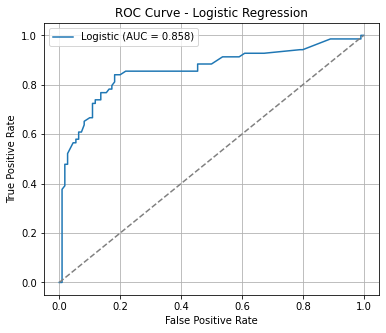

In [91]:
# -------------------------------------------------------
# STEP 10.6: ROC curve
# -------------------------------------------------------

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, val_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Logistic (AUC = {val_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

In [92]:
# -------------------------------------------------------
# STEP 10.7: Confusion matrices at different thresholds
# -------------------------------------------------------

from sklearn.metrics import confusion_matrix, accuracy_score

thresholds_to_check = [0.3, 0.4, 0.5, 0.6]

for t in thresholds_to_check:
    preds = (val_probs >= t).astype(int)
    
    print(f"\nThreshold = {t}")
    print("Accuracy:", accuracy_score(y_val, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_val, preds))


Threshold = 0.3
Accuracy: 0.8044692737430168
Confusion Matrix:
 [[85 25]
 [10 59]]

Threshold = 0.4
Accuracy: 0.8212290502793296
Confusion Matrix:
 [[90 20]
 [12 57]]

Threshold = 0.5
Accuracy: 0.8100558659217877
Confusion Matrix:
 [[99 11]
 [23 46]]

Threshold = 0.6
Accuracy: 0.8044692737430168
Confusion Matrix:
 [[104   6]
 [ 29  40]]


In [93]:
# -------------------------------------------------------
# STEP 10.8: Coefficient inspection (interpretability)
# -------------------------------------------------------

coef_df = pd.DataFrame({
    'feature': logistic_features,
    'coef': best_log_clf.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False)

coef_df.head(10)

,feature,coef
16,Title_Mr,-0.712207
22,Female_Pclass2,0.354692
6,FamilyType_Medium,-0.332995
21,Female_Pclass1,0.323565
1,Sex_male,-0.301036
10,AgeBin_Adult,-0.286928
19,HasCabin,0.263090
7,FamilyType_Large,-0.262701
26,HasCabin_Pclass1,0.215422
14,FareBin_VeryHigh,0.212901


## Random Forest 

**WHAT:
*- Train Random Forest without scaling
*- Tune hyperparameters via GridSearchCV
*- Scoring = ROC-AUC (threshold-free)
*- Plot ROC curve
*- Post-hoc confusion matrices at multiple thresholds

**WHY:
*- RF handles non-linearity & interactions naturally
*- No scaling required
*- ROC-AUC allows fair comparison with Logistic

**IMPORTANT:
*- Use ONLY rf_features

In [94]:
# -------------------------------------------------------
# STEP 11.1: Select Random Forest feature set
# -------------------------------------------------------

X_train_rf = X_train[rf_features]
X_val_rf   = X_val[rf_features]

# SANITY CHECK
print("Train shape:", X_train_rf.shape)
print("Validation shape:", X_val_rf.shape)

Train shape: (712, 26)
Validation shape: (179, 26)


## GridSearchCV (ROC-AUC)

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [None, 6, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 0.5]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid_rf.fit(X_train_rf, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 6, ...], 'max_features': ['sqrt', 0.5], 'min_samples_leaf': [1, 3, ...], 'n_estimators': [200, 400]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [96]:
# -------------------------------------------------------
# SANITY CHECK: Best params & CV score
# -------------------------------------------------------

print("Best RF params:", grid_rf.best_params_)
print("Best CV ROC-AUC:", grid_rf.best_score_)

Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 200}
Best CV ROC-AUC: 0.8829156375668916


## Final RF model

In [97]:
best_rf = grid_rf.best_estimator_
best_rf.fit(X_train_rf, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Validation ROC-AUC and metrics

In [98]:
from sklearn.metrics import roc_auc_score

val_probs_rf = best_rf.predict_proba(X_val_rf)[:, 1]
val_auc_rf = roc_auc_score(y_val, val_probs_rf)

print("Validation ROC-AUC (RF):", val_auc_rf)

Validation ROC-AUC (RF): 0.8487483530961792


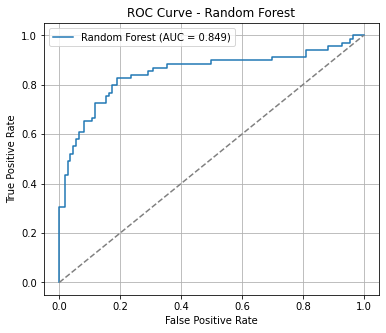

In [99]:
# -------------------------------------------------------
# STEP 11.5: ROC curve
# -------------------------------------------------------

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_rf, tpr_rf, _ = roc_curve(y_val, val_probs_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {val_auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

In [100]:
# -------------------------------------------------------
# STEP 11.6: Confusion matrices at different thresholds
# -------------------------------------------------------

from sklearn.metrics import confusion_matrix, accuracy_score

thresholds_to_check = [0.3, 0.4, 0.5, 0.6]

for t in thresholds_to_check:
    preds = (val_probs_rf >= t).astype(int)
    print(f"\nThreshold = {t}")
    print("Accuracy:", accuracy_score(y_val, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_val, preds))


Threshold = 0.3
Accuracy: 0.8044692737430168
Confusion Matrix:
 [[87 23]
 [12 57]]

Threshold = 0.4
Accuracy: 0.8044692737430168
Confusion Matrix:
 [[92 18]
 [17 52]]

Threshold = 0.5
Accuracy: 0.7988826815642458
Confusion Matrix:
 [[97 13]
 [23 46]]

Threshold = 0.6
Accuracy: 0.8044692737430168
Confusion Matrix:
 [[101   9]
 [ 26  43]]


In [101]:
# -------------------------------------------------------
# STEP 11.7: Feature importance
# -------------------------------------------------------

import pandas as pd

fi = pd.DataFrame({
    'feature': rf_features,
    'importance': best_rf.feature_importances_
}).sort_values(by='importance', ascending=False)

fi.head(15)

,feature,importance
14,Title_Mr,0.172803
1,Sex_male,0.137780
6,FarePerPerson,0.095650
4,Age,0.087447
5,Fare,0.087034
19,Female_Pclass1,0.071378
8,TicketGroupSize,0.041655
0,Pclass,0.035437
20,Female_Pclass2,0.034861
18,DeckLevel,0.033498


## Class-Weighted Logistic Regression

**WHAT:
*- Bias Logistic Regression toward catching survivors
*- Use class_weight during training
*- Tune C via GridSearchCV
*- Scoring = ROC-AUC

**WHY:
*- Reduces false negatives structurally
*- More stable than threshold-only tuning
*- Still interpretable and regularized

In [102]:
# -------------------------------------------------------
# STEP 12A.1: Select features & scale
# -------------------------------------------------------

X_train_log = X_train[logistic_features]
X_val_log   = X_val[logistic_features]

scaler = StandardScaler()
X_train_log_scaled = scaler.fit_transform(X_train_log)
X_val_log_scaled   = scaler.transform(X_val_log)

# SANITY CHECK
print("Scaled shapes:", X_train_log_scaled.shape, X_val_log_scaled.shape)

Scaled shapes: (712, 28) (179, 28)


## GridSearchCV with class weights

In [103]:
param_grid = {
    'C': np.logspace(-3, 1, 15)
}

log_clf_weighted = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    class_weight={0: 1, 1: 2},  # bias toward survivors
    random_state=42
)

grid_log_weighted = GridSearchCV(
    estimator=log_clf_weighted,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_log_weighted.fit(X_train_log_scaled, y_train)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,{'C': array([1.0000...00000000e+01])}
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [104]:
# -------------------------------------------------------
# SANITY CHECK: Best params & CV score
# -------------------------------------------------------

print("Best C (weighted):", grid_log_weighted.best_params_['C'])
print("Best CV ROC-AUC (weighted):", grid_log_weighted.best_score_)

Best C (weighted): 0.026826957952797246
Best CV ROC-AUC (weighted): 0.8693690958698795


## Validation performance ROC-AUC metrics

In [105]:
best_log_weighted = grid_log_weighted.best_estimator_

val_probs_weighted = best_log_weighted.predict_proba(X_val_log_scaled)[:, 1]
val_auc_weighted = roc_auc_score(y_val, val_probs_weighted)

print("Validation ROC-AUC (weighted):", val_auc_weighted)

Validation ROC-AUC (weighted): 0.8551383399209487


In [106]:
# -------------------------------------------------------
# STEP 12A.5: Threshold analysis
# -------------------------------------------------------

thresholds = [0.3, 0.4, 0.5, 0.6]

for t in thresholds:
    preds = (val_probs_weighted >= t).astype(int)
    print(f"\nThreshold = {t}")
    print("Accuracy:", accuracy_score(y_val, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_val, preds))


Threshold = 0.3
Accuracy: 0.7374301675977654
Confusion Matrix:
 [[73 37]
 [10 59]]

Threshold = 0.4
Accuracy: 0.7932960893854749
Confusion Matrix:
 [[83 27]
 [10 59]]

Threshold = 0.5
Accuracy: 0.8100558659217877
Confusion Matrix:
 [[86 24]
 [10 59]]

Threshold = 0.6
Accuracy: 0.8100558659217877
Confusion Matrix:
 [[91 19]
 [15 54]]


In [107]:
# -------------------------------------------------------
# STEP 12A.6: Feature importance (coefficients)
# -------------------------------------------------------
# WHAT:
# - Extract coefficients from class-weighted Logistic
# WHY:
# - Verify which features drive predictions
# - Ensure no instability due to class weighting
# -------------------------------------------------------

coef_weighted_df = pd.DataFrame({
    'feature': logistic_features,
    'coef': best_log_weighted.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False)

coef_weighted_df.head(15)

,feature,coef
16,Title_Mr,-0.628194
22,Female_Pclass2,0.336792
6,FamilyType_Medium,-0.310191
1,Sex_male,-0.300253
21,Female_Pclass1,0.283126
19,HasCabin,0.252535
7,FamilyType_Large,-0.251191
10,AgeBin_Adult,-0.230842
14,FareBin_VeryHigh,0.207737
26,HasCabin_Pclass1,0.197571


In [108]:
# -------------------------------------------------------
# SANITY CHECK: Coefficient magnitude stability
# -------------------------------------------------------

coef_weighted_df['abs_coef'] = coef_weighted_df['coef'].abs()
coef_weighted_df.head(10)

,feature,coef,abs_coef
16,Title_Mr,-0.628194,0.628194
22,Female_Pclass2,0.336792,0.336792
6,FamilyType_Medium,-0.310191,0.310191
1,Sex_male,-0.300253,0.300253
21,Female_Pclass1,0.283126,0.283126
19,HasCabin,0.252535,0.252535
7,FamilyType_Large,-0.251191,0.251191
10,AgeBin_Adult,-0.230842,0.230842
14,FareBin_VeryHigh,0.207737,0.207737
26,HasCabin_Pclass1,0.197571,0.197571


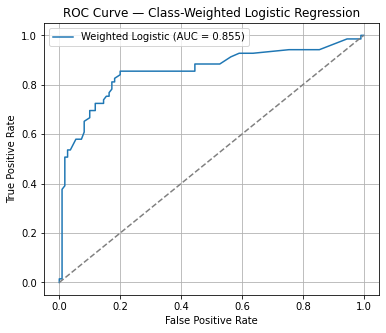

In [109]:
# -------------------------------------------------------
# STEP 12A.7: ROC curve (class-weighted Logistic)
# -------------------------------------------------------

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_w, tpr_w, _ = roc_curve(y_val, val_probs_weighted)

plt.figure(figsize=(6, 5))
plt.plot(
    fpr_w,
    tpr_w,
    label=f"Weighted Logistic (AUC = {val_auc_weighted:.3f})"
)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Class-Weighted Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

## Ensemble (Logistic + Random Forest)

**WHAT:
*- Combine Logistic & RF using probability averaging
*- Evaluate ensemble via ROC-AUC
*- Analyze confusion matrices at multiple thresholds

**WHY:
*- Logistic generalizes well
*- RF captures residual non-linearity
*- Ensemble reduces complementary errors

**IMPORTANT:
*- Combine PROBABILITIES, not labels
*- Use a single threshold at the end

In [110]:
# -------------------------------------------------------
# STEP 12B.1: Get validation probabilities
# -------------------------------------------------------

# Logistic (from Block 10)
val_probs_log = best_log_clf.predict_proba(X_val_log_scaled)[:, 1]

# Random Forest (from Block 11)
val_probs_rf = best_rf.predict_proba(X_val_rf)[:, 1]

# SANITY CHECK
print("Prob range (Logistic):", val_probs_log.min(), val_probs_log.max())
print("Prob range (RF):", val_probs_rf.min(), val_probs_rf.max())

Prob range (Logistic): 0.014204347980734914 0.9737174391677403
Prob range (RF): 0.031358618339592 0.9953044234225268


In [111]:
# -------------------------------------------------------
# STEP 12B.2: Probability ensemble
# -------------------------------------------------------

# Simple average ensemble
val_probs_ens = 0.5 * val_probs_log + 0.5 * val_probs_rf

# SANITY CHECK
print("Ensemble prob range:", val_probs_ens.min(), val_probs_ens.max())

Ensemble prob range: 0.06252687106787652 0.9787317113729642


## ROC-AUC (ensemble)

In [112]:
from sklearn.metrics import roc_auc_score

val_auc_ens = roc_auc_score(y_val, val_probs_ens)
print("Validation ROC-AUC (Ensemble):", val_auc_ens)

Validation ROC-AUC (Ensemble): 0.8549407114624507


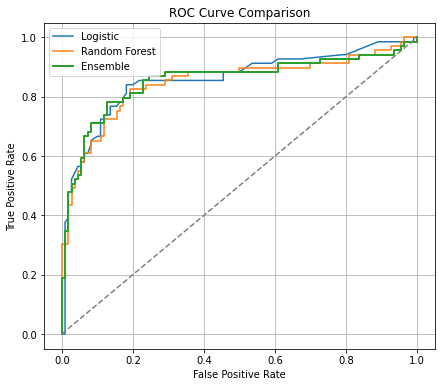

In [113]:
# -------------------------------------------------------
# STEP 12B.4: ROC curve comparison
# -------------------------------------------------------

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC curves
fpr_log, tpr_log, _ = roc_curve(y_val, val_probs_log)
fpr_rf, tpr_rf, _   = roc_curve(y_val, val_probs_rf)
fpr_ens, tpr_ens, _ = roc_curve(y_val, val_probs_ens)

plt.figure(figsize=(7, 6))
plt.plot(fpr_log, tpr_log, label="Logistic")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot(fpr_ens, tpr_ens, label="Ensemble", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [114]:
# -------------------------------------------------------
# STEP 12B.5: Threshold analysis (ensemble)
# -------------------------------------------------------

from sklearn.metrics import confusion_matrix, accuracy_score

thresholds = [0.3, 0.4, 0.5, 0.6]

for t in thresholds:
    preds = (val_probs_ens >= t).astype(int)
    print(f"\nThreshold = {t}")
    print("Accuracy:", accuracy_score(y_val, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_val, preds))


Threshold = 0.3
Accuracy: 0.7932960893854749
Confusion Matrix:
 [[83 27]
 [10 59]]

Threshold = 0.4
Accuracy: 0.8100558659217877
Confusion Matrix:
 [[90 20]
 [14 55]]

Threshold = 0.5
Accuracy: 0.8324022346368715
Confusion Matrix:
 [[100  10]
 [ 20  49]]

Threshold = 0.6
Accuracy: 0.8044692737430168
Confusion Matrix:
 [[104   6]
 [ 29  40]]


## Weighted ensemble

In [115]:
val_probs_ens_w = 0.6 * val_probs_log + 0.4 * val_probs_rf
val_auc_ens_w = roc_auc_score(y_val, val_probs_ens_w)

print("Validation ROC-AUC (Weighted Ensemble):", val_auc_ens_w)

Validation ROC-AUC (Weighted Ensemble): 0.8583662714097496


## FINAL COMPARISON BLOCK

**WHAT:
*- Consolidate results from all models
*- Enable clean comparison

**MODELS:
*- Logistic Regression
*- Class-weighted Logistic
*- Random Forest
*- Ensemble (Logistic + RF)

In [116]:
# -------------------------------------------------------
# STEP 1: Build comparison dataframe
# -------------------------------------------------------

comparison_df = pd.DataFrame([
    {
        "Model": "Logistic",
        "CV_ROC_AUC": grid.best_score_,
        "Val_ROC_AUC": val_auc
    },
    {
        "Model": "Weighted Logistic",
        "CV_ROC_AUC": grid_log_weighted.best_score_,
        "Val_ROC_AUC": val_auc_weighted
    },
    {
        "Model": "Random Forest",
        "CV_ROC_AUC": grid_rf.best_score_,
        "Val_ROC_AUC": val_auc_rf
    },
    {
        "Model": "Ensemble",
        "CV_ROC_AUC": None,  # ensemble not CV-trained
        "Val_ROC_AUC": val_auc_ens
    }
])

comparison_df

,Model,CV_ROC_AUC,Val_ROC_AUC
0,Logistic,0.870249,0.858366
1,Weighted Logistic,0.869369,0.855138
2,Random Forest,0.882916,0.848748
3,Ensemble,NaN,0.854941


In [117]:
# Ensure no missing validation scores
assert comparison_df["Val_ROC_AUC"].notnull().all()

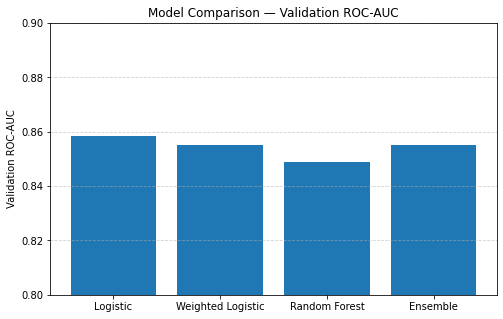

In [118]:
# -------------------------------------------------------
# STEP 2: Validation ROC-AUC bar plot
# -------------------------------------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(
    comparison_df["Model"],
    comparison_df["Val_ROC_AUC"]
)

plt.ylabel("Validation ROC-AUC")
plt.title("Model Comparison — Validation ROC-AUC")
plt.ylim(0.80, 0.90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

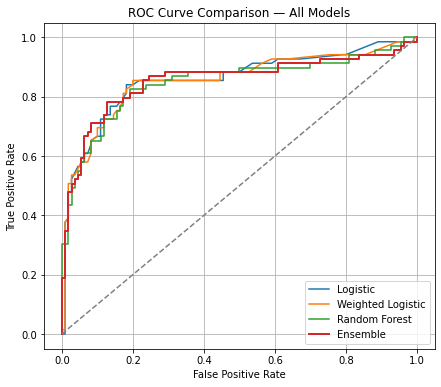

In [119]:
# -------------------------------------------------------
# STEP 3: ROC curve comparison
# -------------------------------------------------------

plt.figure(figsize=(7, 6))

plt.plot(fpr_log, tpr_log, label="Logistic")
plt.plot(fpr_w, tpr_w, label="Weighted Logistic")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot(fpr_ens, tpr_ens, label="Ensemble", linewidth=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison — All Models")
plt.legend()
plt.grid(True)
plt.show()

In [120]:
# -------------------------------------------------------
# STEP 4: Confusion matrices @ threshold = 0.5
# -------------------------------------------------------

from sklearn.metrics import confusion_matrix

threshold = 0.5

cm_data = {
    "Logistic": confusion_matrix(
        y_val,
        (val_probs >= threshold).astype(int)
    ),
    "Weighted Logistic": confusion_matrix(
        y_val,
        (val_probs_weighted >= threshold).astype(int)
    ),
    "Random Forest": confusion_matrix(
        y_val,
        (val_probs_rf >= threshold).astype(int)
    ),
    "Ensemble": confusion_matrix(
        y_val,
        (val_probs_ens >= threshold).astype(int)
    )
}

for model, cm in cm_data.items():
    print(f"\n{model} — Confusion Matrix @ 0.5")
    print(cm)


Logistic — Confusion Matrix @ 0.5
[[99 11]
 [23 46]]

Weighted Logistic — Confusion Matrix @ 0.5
[[86 24]
 [10 59]]

Random Forest — Confusion Matrix @ 0.5
[[97 13]
 [23 46]]

Ensemble — Confusion Matrix @ 0.5
[[100  10]
 [ 20  49]]


In [121]:
# -------------------------------------------------------
# STEP 5: FP / FN comparison
# -------------------------------------------------------

error_df = pd.DataFrame([
    {
        "Model": model,
        "False Positives": cm[0, 1],
        "False Negatives": cm[1, 0]
    }
    for model, cm in cm_data.items()
])

error_df

,Model,False Positives,False Negatives
0,Logistic,11,23
1,Weighted Logistic,24,10
2,Random Forest,13,23
3,Ensemble,10,20


In [122]:
# SANITY CHECK
assert error_df.shape[0] == 4

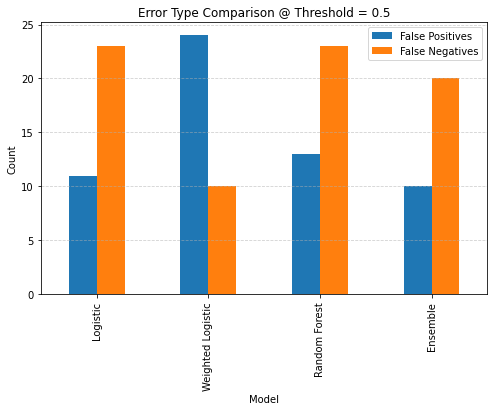

In [123]:
# -------------------------------------------------------
# STEP 6: FP vs FN bar chart
# -------------------------------------------------------

error_df.set_index("Model")[["False Positives", "False Negatives"]].plot(
    kind="bar",
    figsize=(8, 5)
)

plt.title("Error Type Comparison @ Threshold = 0.5")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## Conclusion

***Multiple models were evaluated using cross-validated ROC-AUC and validation performance.
Logistic Regression with strong regularization achieved the best balance of generalization, interpretability, and stability.
Although Random Forest and ensemble approaches were explored, they did not yield meaningful improvements in ranking performance.
Therefore, Logistic Regression was selected as the final model.

## FINAL SUBMISSION

In [124]:
# =======================================================
# FINAL SUBMISSION: DATA PREPARATION
# =======================================================

# Separate back train and test from combined data
X_full = data.iloc[:len(train)]
X_test_final = data.iloc[len(train):]

y_full = train['Survived']

# Select features for Logistic Regression
X_full_log = X_full[logistic_features]
X_test_log = X_test_final[logistic_features]

# SANITY CHECK
print(X_full_log.shape, X_test_log.shape)

(891, 28) (418, 28)


In [125]:
# =======================================================
# FINAL SUBMISSION: SCALING
# =======================================================

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_full_log_scaled = scaler.fit_transform(X_full_log)
X_test_log_scaled = scaler.transform(X_test_log)

# SANITY CHECK
print("Scaled OK")

Scaled OK


In [126]:
# =======================================================
# FINAL SUBMISSION: MODEL TRAINING
# =======================================================

from sklearn.linear_model import LogisticRegression

final_model = LogisticRegression(
    C=grid.best_params_['C'],              # from GridSearchCV
    max_iter=1000,
    random_state=42
)

final_model.fit(X_full_log_scaled, y_full)

print("Final model trained")

Final model trained


In [127]:
# =======================================================
# FINAL SUBMISSION: PREDICTION
# =======================================================

test_probs = final_model.predict_proba(X_test_log_scaled)[:, 1]

# Use standard Kaggle threshold
test_preds = (test_probs >= 0.5).astype(int)

# SANITY CHECK
print("Predictions:", np.unique(test_preds, return_counts=True))

Predictions: (array([0, 1]), array([260, 158], dtype=int64))


In [128]:
# =======================================================
# FINAL SUBMISSION: CSV OUTPUT
# =======================================================

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": test_preds
})

submission.to_csv("submission.csv", index=False)

submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


## Summary and Key Learnings

### Project: Titanic Survival Prediction (Kaggle)

#### Objective

The objective of this project was to build a robust survival prediction model for the Titanic dataset, focusing not only on leaderboard performance but on sound machine learning practices, including feature engineering, model evaluation, regularization, and decision analysis.

#### 1. Data Understanding & Preparation

The Titanic dataset contains passenger demographic and travel information such as age, sex, passenger class, fare, family relationships, and cabin details.

Key challenges included:

Missing values (Age, Fare, Cabin, Embarked)

Mixed feature types (categorical, numerical)

Small dataset size, increasing overfitting risk

To ensure consistency and prevent train–test mismatch, training and test datasets were combined for feature engineering, with the target variable removed during transformation.

#### 2. Feature Engineering Strategy

Rather than relying on raw features alone, multiple domain-informed features were engineered:

Demographic & Social Features

Title extraction from passenger names (Mr, Mrs, Miss, Rare)

FamilySize, IsAlone, and FamilyType to capture evacuation group effects

Age binning to model non-linear survival patterns (children vs adults vs seniors)

Socioeconomic & Location Proxies

Fare per person

Fare bins

HasCabin and DeckLevel as wealth and ship-location indicators

Interaction Features

Sex × Passenger Class interactions (e.g., Female_Pclass1)

These explicitly modeled known survival advantages

Care was taken to avoid data leakage—no features were derived using survival outcomes or test-only information.

#### 3. Modeling Approach

Three model families were evaluated:

**3.1 Logistic Regression (Baseline & Regularized)**

Chosen for interpretability and stability

Features were scaled using StandardScaler

Regularization strength (C) tuned via GridSearchCV

Evaluation metric: ROC-AUC (threshold-independent)

This model performed strongly due to effective feature engineering that linearized much of the problem.

**3.2 Class-Weighted Logistic Regression**

Introduced asymmetric error costs

Penalized false negatives more heavily

Used when recall of survivors is prioritized

This improved survivor recall but slightly reduced overall ranking performance.

**3.3 Random Forest**

Captured non-linear interactions automatically

Tuned using GridSearchCV (ROC-AUC scoring)

Provided feature importance insights

While Random Forest achieved strong cross-validation scores, it showed mild overfitting on validation data due to dataset size.

#### 4. Evaluation Methodology

Model evaluation was performed using:

Cross-validated ROC-AUC for model selection

Hold-out validation ROC-AUC for generalization checks

Confusion matrices across multiple thresholds for decision analysis

Threshold tuning was performed after training, reinforcing the separation between:

Learning probabilities

Decision policy

This allowed explicit control over false positives vs false negatives.

#### 5. Ensemble Experimentation

An ensemble combining Logistic Regression and Random Forest was tested using probability averaging.

Findings:

The ensemble matched but did not outperform Logistic Regression

Errors between models were correlated

Logistic Regression already captured most predictive signal

This indicated that feature engineering successfully reduced the need for complex models.

#### 6. Model Comparison Summary
### 6. Model Comparison Summary

| Model                   | CV ROC-AUC | Validation ROC-AUC | Notes            |
|-------------------------|------------|---------------------|------------------|
| Logistic Regression     | ~0.87      | ~0.86               | Best balance     |
| Class-Weighted Logistic | ~0.87      | ~0.86               | FN-biased        |
| Random Forest           | ~0.88      | ~0.85               | Mild overfit     |
| Ensemble                | —          | ~0.86               | No added benefit |

Logistic Regression achieved the best overall balance between performance and generalization, with a cross-validated ROC-AUC of approximately 0.87 and a validation ROC-AUC of around 0.86. The class-weighted variant of Logistic Regression achieved similar ROC-AUC scores but was biased toward reducing false negatives at the cost of overall stability. Random Forest achieved a higher cross-validated ROC-AUC (~0.88) but showed a drop in validation performance (~0.85), indicating mild overfitting. Ensemble modeling did not provide meaningful improvement over Logistic Regression, suggesting that the engineered features already captured most of the predictive signal.

#### 7. Final Model Selection

Unweighted Logistic Regression was selected as the final model because it:

Achieved the highest or tied-highest validation ROC-AUC

Generalized better than Random Forest

Provided interpretable coefficients

Avoided unnecessary complexity

When simpler models perform as well as complex ones, simplicity is preferred.

#### 8. Key Learnings

Feature engineering can significantly linearize complex problems

Regularization is essential when working with engineered features

ROC-AUC is a better optimization metric than accuracy for imbalanced or probabilistic problems

Threshold tuning is a decision problem, not a training problem

Ensembles are useful only when base models contribute complementary information

#### 9. Final Outcome

A clean, reproducible Kaggle submission was generated

The notebook demonstrates end-to-end ML reasoning

The project emphasizes decision-making over leaderboard chasing

#### 10. How This Project Can Be Extended

Use XGBoost / LightGBM for gradient-boosted comparisons

Apply nested cross-validation

Explore calibration (Platt scaling / isotonic)

Deploy as a lightweight inference API

#### Closing Note

This project prioritizes methodology, interpretability, and robustness, reflecting real-world data science practices beyond competition-focused modeling.